# 對PTT汽車版「電動車」進行情緒分析

**Group:** 4<br>
**組員:** 翁忠宇、董庭妤、林佳融、姚慕東<br>
**Date created:** 2023/04/12<br>
**Last modified:** 2023/04/20<br><br>

## 報告影片連結
[Group4](https://youtu.be/u7aAoLgbabY)

### 動機與分析目的

近年來，隨著環保與再生能源意識提升，以及政府對於電動車的補助政策，<br>
消費者對於低碳排、新能源交通工具之需求隨之增加，<br>
電動車也逐漸成為消費者考量的選擇之一，從過去銷售佔比可看出，<br>
2021年銷售佔比為1.57%，到了2022年銷售佔比成長為3.75%，銷售成長幅度巨大，<br>
從此可看出未來電動車的成長幅度還有很大的空間。<br>

然而，台灣在電動車市場的發展處於起步階段，<br>
影響台灣消費者的購買因素的研究卻不如國外豐沛。<br>
因此，本研究這次透過爬蟲抓取網路使用者對於電動車的文章及回覆，<br>
了解哪些因素會影響國內消費者購買電動車，<br>
相信對於擴大台灣電動車市場有相當重要的意義。<br>

這次的研究主要在探討「**影響台灣消費者購買電動車之重要因素**」，<br>
例如:價格、性能、充電樁等，觀察這些因素在是否會隨著時間改變而產生不一樣的結果，<br>
抑或是因為事件的發生才導致消費者開始關注的議題。<br>
並以此為基礎，提供台灣電動車廠商行銷上的建議，<br>
加速台灣電動車市場的發展與綠色能源的使用，<br>
也希望可以透過本次的研究，讓台灣消費者更加了解在電動車領域中近期熱議的話題，<br>
也期望可作爲未來購車的建議。

### 安裝套件

In [ ]:
from datetime import datetime
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from wordcloud import WordCloud
from nltk import ngrams
from nltk import FreqDist
import jieba
import networkx as nx
import math
%matplotlib inline

In [ ]:
# plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
fprop = fm.FontProperties(fname="./SourceHanSansTW-Regular.otf")
fprop


# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

## 資料前處理
使用「電動車」作為關鍵字，從工作流程系統中將 ptt 資料下載下來

### 基本資料介紹
資料來源：
+ 工作流程平台蒐集PTT 汽車版(Car)文章
+ 關鍵字:「電動車」(995筆)
+ 時間: 2022-04-01 ~ 2023-04-15

In [ ]:
df = pd.read_csv("./data/car.csv")
df = df.rename(columns={"artContent": "sentence"})
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,sentence,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/car/M.1648778137.A.72B....,[受訪]電動汽車充電行為與使用研究(徵受訪者),2022-04-01 09:55:34,edian,car,本文經Munezsu板主核准\n各位Car版的版友好，\n\n我們是\nBLD\nEnerg...,[],61.227.169.165,2022-04-02 00:06:23,ptt
1,2,https://www.ptt.cc/bbs/car/M.1648821343.A.2E5....,[電車]model31年半4萬公里花費,2022-04-01 21:55:39,mk203125,car,人生第一台車\n\n本來滿一年時想發個心得(花費)才發現第一年連保養里程都不到\n\n透天+...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""wuii0306"", ""...",1.34.96.153,2022-04-02 00:06:29,ptt
2,3,https://www.ptt.cc/bbs/car/M.1648894717.A.DDC....,Re:[討論]為什麼Model3越賣越好？,2022-04-02 18:18:33,asdhse,car,發這文，你後悔了嗎？\n現在入門要174萬惹，自從真特黑和假特粉都下去後，就沒有人可以阻止特...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""ISNAKEI"", ""c...",114.137.122.238,2022-04-02 23:29:31,ptt
3,4,https://www.ptt.cc/bbs/car/M.1648907890.A.C6F....,[新聞]原材料短缺德國汽車產業驚恐,2022-04-02 21:58:07,yamatobar,car,原文連結：\nhttps://reurl.cc/xOyGoN\n原文內容：\n\n（德國之聲...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""iwei0930"", ""...",114.24.105.175,2022-04-02 23:29:33,ptt
4,5,https://www.ptt.cc/bbs/car/M.1648953237.A.DDB....,[問題]XC90退休後的通勤車選擇,2022-04-03 10:33:55,morrislek,car,家裏的XC90（2018年式）即將屆滿五年，每日通勤車，目前里程數將近20萬公里，預計保固內...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Lowpapa"", ""c...",118.169.86.172,2022-04-04 01:05:43,ptt


去除空值、換行、網址

In [ ]:
clear_df = df.copy()

# 去除有包含空值的筆數
clear_df.dropna(axis=0, how="any", inplace=True)

# 用'。'取代'\n\n'，並移除'\n'
clear_df = clear_df.replace("\\n\\n", "。", regex=True).replace("\n", "", regex=True)

# 移除內文中的網址
clear_df["sentence"] = (
    clear_df["sentence"]
    .replace(r"http\S+", "", regex=True)
    .replace(r"www\S+", "", regex=True)
    .replace(r"\d+", "", regex=True)
)

In [ ]:
clear_df["sentence"] = clear_df["sentence"].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode("sentence").reset_index(drop=True)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

設定斷詞系統字典，在這邊我們是使用Jieba作為我們的斷詞系統

In [ ]:
jieba.set_dictionary("dict/dict.txt")
jieba.load_userdict("dict/user_dict.txt")

Building prefix dict from C:\Users\dnlki\SOCIAL MEDIA ANALYSIS\proj1\sentiment\dict\dict.txt ...
Loading model from cache C:\Users\dnlki\AppData\Local\Temp\jieba.u7b0d0e2c9756b1dd53793f0f68a3658a.cache
Loading model cost 0.403 seconds.
Prefix dict has been built successfully.


In [ ]:
sent_df["sentence"] = (
    sent_df["sentence"].str.replace(r"[^\w\s\d]+", "", regex=True).astype(str)
)
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

In [ ]:
word_df = (
    sent_df.assign(word=sent_df["sentence"].apply(jieba.lcut))
    .explode("word")
    .drop(["sentence"], axis=1)
)
word_df = word_df.loc[word_df["word"].str.len() > 1]

移除停用字

In [ ]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [
    line.strip()
    for line in open("dict/stopwords.txt", "r", encoding="utf-8").readlines()
]

In [ ]:
noStop_df = word_df[~word_df["word"].isin(stopwords)]

In [ ]:
noStop_df["word"].value_counts().to_csv("./freq.csv")

## lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 準備LIWC字典  

In [ ]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [ ]:
liwc_dict['sentiments'].value_counts()

affect      2061
negative    1172
positive     730
anger        358
sad          192
anx          169
Name: sentiments, dtype: int64

In [ ]:
ptt_df = noStop_df.copy()
ptt_df["artDate"] = pd.to_datetime(ptt_df["artDate"])

In [ ]:
ptt_df["artDate"].describe(datetime_is_numeric=True)

count                           135082
mean     2022-10-15 01:54:12.353474048
min                2022-04-01 09:55:34
25%                2022-07-09 22:42:15
50%                2022-10-27 22:59:16
75%                2023-01-16 10:02:10
max                2023-04-14 20:48:16
Name: artDate, dtype: object

In [ ]:
ptt_df["artDate"] = ptt_df["artDate"].dt.date

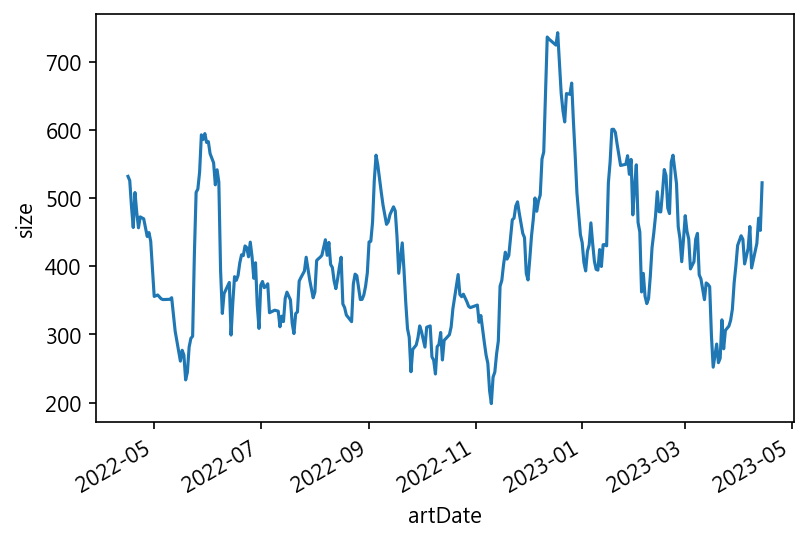

In [ ]:
ptt_line_plot = ptt_df.groupby(["artDate"], as_index=False).size()

fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_line_plot["artDate"], ptt_line_plot["size"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel('size')
fig.autofmt_xdate()
plt.show()

可以看到 2022年6、12月發文量急遽增加，可能是因為鴻海電動車。

### 情緒字典與斷詞結果進行合併

In [ ]:
ptt_liwc_df = pd.merge(ptt_df[["artDate", "artUrl", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artDate,artUrl,word,sentiments
0,2022-04-01,https://www.ptt.cc/bbs/car/M.1648778137.A.72B....,板主,NaN
1,2022-04-01,https://www.ptt.cc/bbs/car/M.1648778137.A.72B....,核准,NaN
2,2022-04-01,https://www.ptt.cc/bbs/car/M.1648778137.A.72B....,友好,affect
3,2022-04-01,https://www.ptt.cc/bbs/car/M.1648778137.A.72B....,BLDEnergy,NaN
4,2022-04-01,https://www.ptt.cc/bbs/car/M.1648778137.A.72B....,線上,NaN
...,...,...,...,...
141609,2023-04-14,https://www.ptt.cc/bbs/car/M.1681476499.A.5E3....,稅率,NaN
141610,2023-04-14,https://www.ptt.cc/bbs/car/M.1681476499.A.5E3....,台灣,NaN
141611,2023-04-14,https://www.ptt.cc/bbs/car/M.1681476499.A.5E3....,還高,NaN
141612,2023-04-14,https://www.ptt.cc/bbs/car/M.1681476499.A.5E3....,北歐,NaN


### 1. 一年內對電動車的情緒波動
14天平均

分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [ ]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"], dropna=False, as_index=False).size()
)
sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])

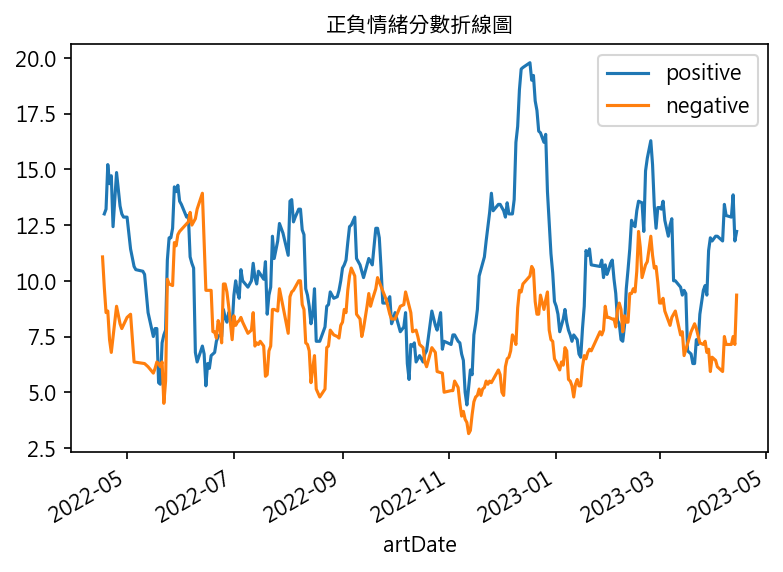

In [ ]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天移動平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

畫出每天的情緒總分數，可以看到通常正面的分數都會超過負面，但起伏還是很大，可見大家對電動車評價不一。12月因為中國BYD銷售量高而出現很多正面情緒。

2022年6月對於電動車的情緒較負面。

### 2. 一年內正負面情緒字

In [ ]:
mask = (ptt_liwc_df["artDate"].notnull())
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

正面情緒文字雲

(-0.5, 399.5, 199.5, -0.5)

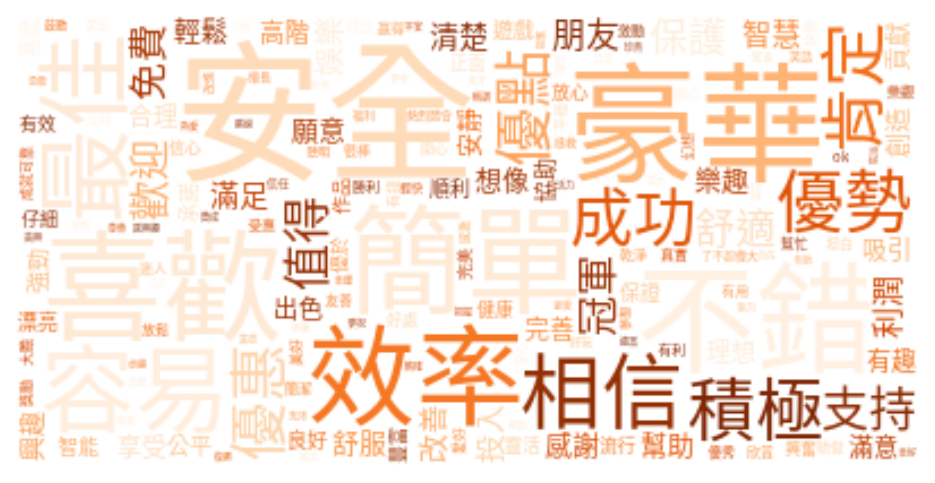

In [ ]:
mask = (ptt_liwc_df["artDate"].notnull()) & (
    ptt_liwc_df["sentiments"] == "positive"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="Oranges")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

(-0.5, 399.5, 199.5, -0.5)

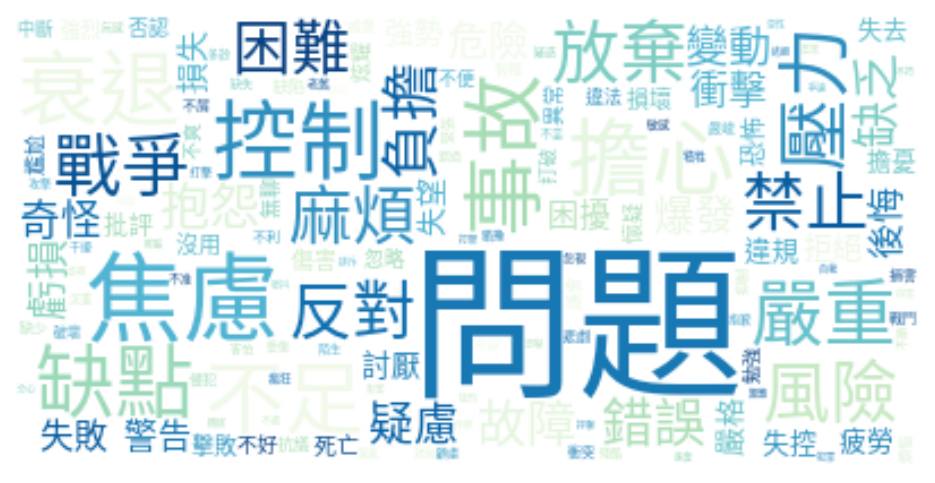

In [ ]:
mask = (ptt_liwc_df["artDate"].notnull()) & (
    ptt_liwc_df["sentiments"] == "negative"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

### 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [ ]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

C:\Users\dnlki\AppData\Local\Temp\ipykernel_9440\1240047314.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\dnlki\AppData\Local\Temp\ipykernel_9440\1240047314.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

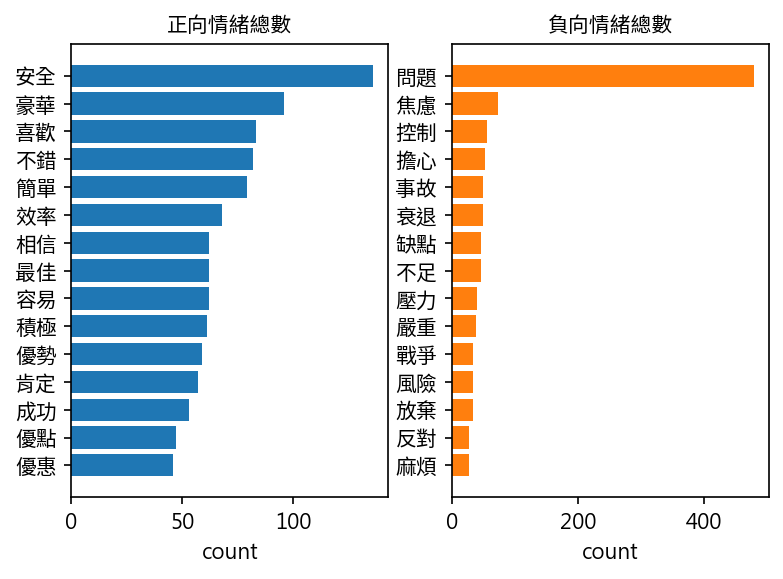

In [ ]:
pos = word_of_pos.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]
neg = word_of_neg.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

6月因電動車自燃、Toyota 電動休旅bZ4X輪圈螺栓會鬆動造成輪胎脫落，因此進行全球性召回、特斯拉男喊「爸過世」想先充電遭拒竟掏槍，造成電動車負面情緒較高。

從正向情緒得知，鄉民注重電動車的"安全"、"豪華"程度；同時也擔心電動車可能衍伸出的"問題"。

透過Jieba斷詞與N-gram幫助建立字典，了解什麼樣的功能是鄉民們在乎的以及其認為需要改善的

In [ ]:
# 新增電動車相關自定義字典
jieba.load_userdict('./dict/car_lexicon.txt')

In [ ]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [ ]:
car_bigram = sent_df.copy()
car_bigram["word"] = car_bigram.sentence.apply(bigram_getToken_dict)
car_bigram = car_bigram.explode('word')

In [ ]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

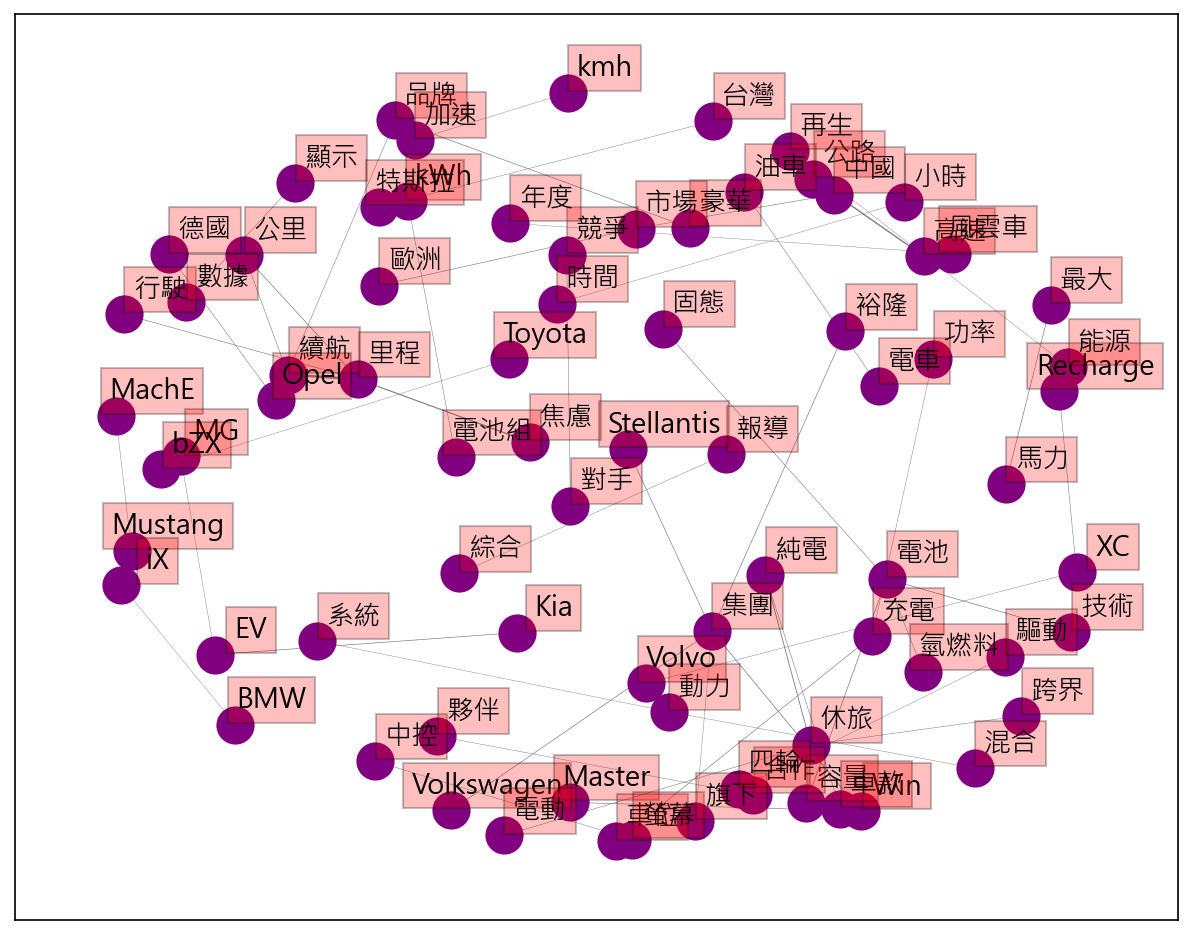

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

鄉民對於電動車"車款"、"電池"、"馬力"、"續航"、"加速"、"驅動"等關注度都很高

特斯拉換成固態電池。<br>
Volvo推出插電式混合。<br>
Toyota推出氫燃料電池。<br>

### 4. 探討特定月份造成對於電動車的情緒較低
2022年6月對於電動車的情緒較負面，因此我們想要分析常被討論的正負面情緒字。

In [ ]:
mask = (ptt_liwc_df['artDate'].notnull())
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

D:\Users\dnlki\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


(-0.5, 399.5, 199.5, -0.5)

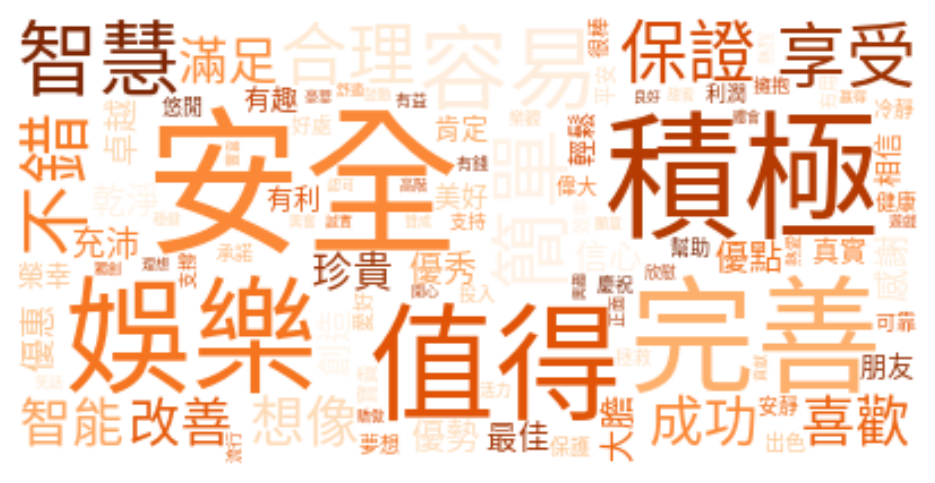

In [ ]:
start_date = pd.Timestamp('2022-06-01')
end_date = pd.Timestamp('2022-06-30')
mask = (ptt_liwc_df['artDate'] >= start_date) & (
    ptt_liwc_df['artDate'] <= end_date) & (
    ptt_liwc_df["sentiments"] == "positive"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="Oranges")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

電動車的"安全"性、值不"值得"、"完善"程度等常被討論。

D:\Users\dnlki\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


(-0.5, 399.5, 199.5, -0.5)

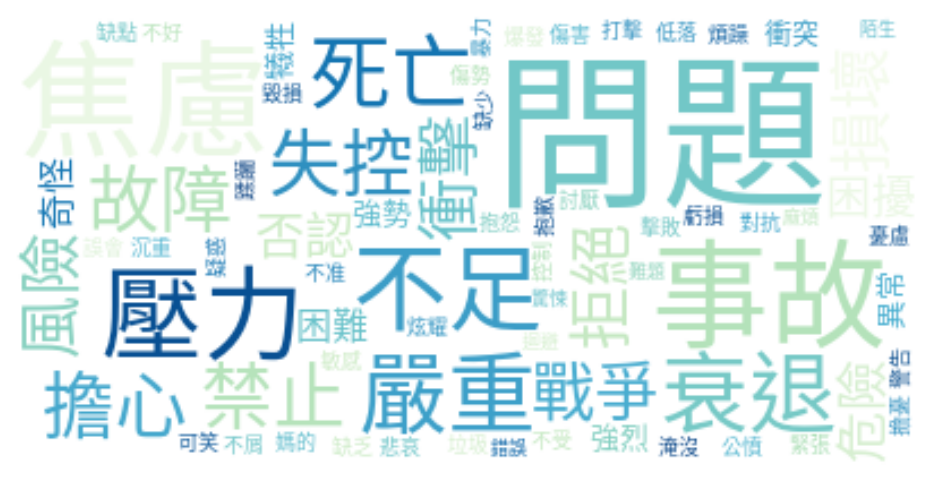

In [ ]:
mask = (ptt_liwc_df['artDate'] >= start_date) & (
    ptt_liwc_df['artDate'] <= end_date) & (
    ptt_liwc_df["sentiments"] == "negative"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

電動車的"問題"、"事故"常令人們感到"壓力"和"焦慮"。

### 情緒代表字
從6月的文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [ ]:
mask = (ptt_liwc_df['artDate'] >= start_date) & (
    ptt_liwc_df['artDate'] <= end_date) & (
    ptt_liwc_df["sentiments"].isin(['positive', 'negative'])
)

ptt_df_date = ptt_liwc_df.loc[mask, ["artDate", "word", "sentiments"]]
ptt_df_date_senti = ptt_df_date.groupby(["sentiments", "word"], as_index=False).size()

D:\Users\dnlki\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


C:\Users\dnlki\AppData\Local\Temp\ipykernel_9440\2491393288.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\dnlki\AppData\Local\Temp\ipykernel_9440\2491393288.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


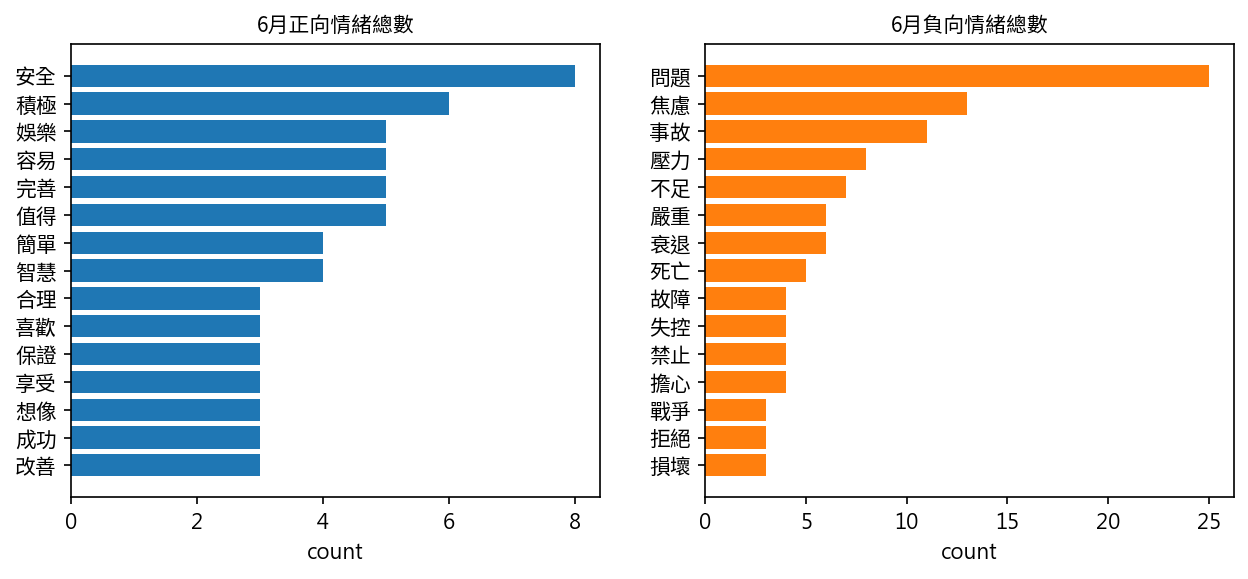

In [ ]:
pos = ptt_df_date_senti[(ptt_df_date_senti["sentiments"] == "positive")].sort_values(
    ["size"], ascending=True
)
pos = pos[-15:]
neg = ptt_df_date_senti[ptt_df_date_senti["sentiments"] == "negative"].sort_values(
    ["size"], ascending=True
)
neg = neg[-15:]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_title(f"6月正向情緒總數", fontproperties=fprop)
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_title(f"6月負向情緒總數", fontproperties=fprop)
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
plt.show()

### 5. 探討特定月份前、當月、當月後關鍵字

2022年6月前

In [ ]:
end_date = pd.Timestamp('2022-06-01')
mask = (ptt_liwc_df['artDate'] < end_date)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

D:\Users\dnlki\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


(-0.5, 399.5, 199.5, -0.5)

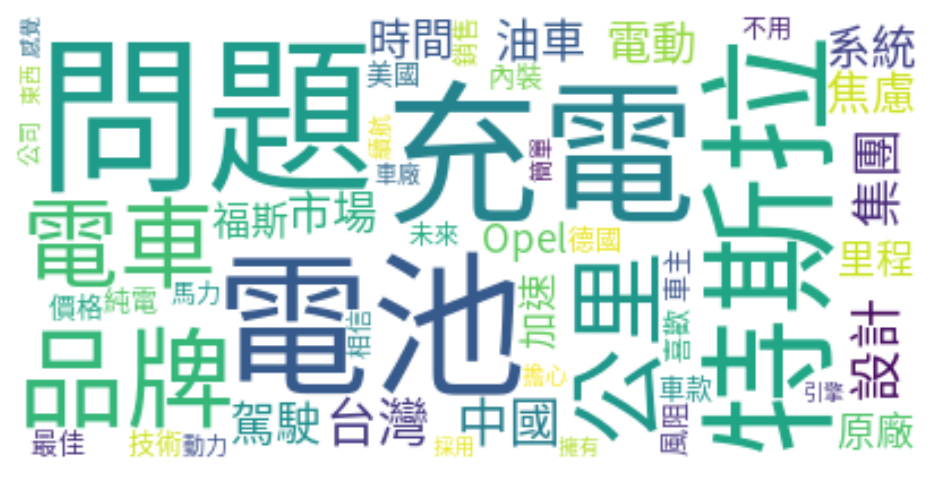

In [ ]:
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=50, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

主要討論"充電"、"電池"、"問題"、"台灣"、"品牌"、"特斯拉"。

2022年6月

In [ ]:
start_date = pd.Timestamp('2022-06-01')
end_date = pd.Timestamp('2022-06-30')
mask = (ptt_liwc_df['artDate'] >= start_date) & (
    ptt_liwc_df['artDate'] <= end_date)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

D:\Users\dnlki\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


(-0.5, 399.5, 199.5, -0.5)

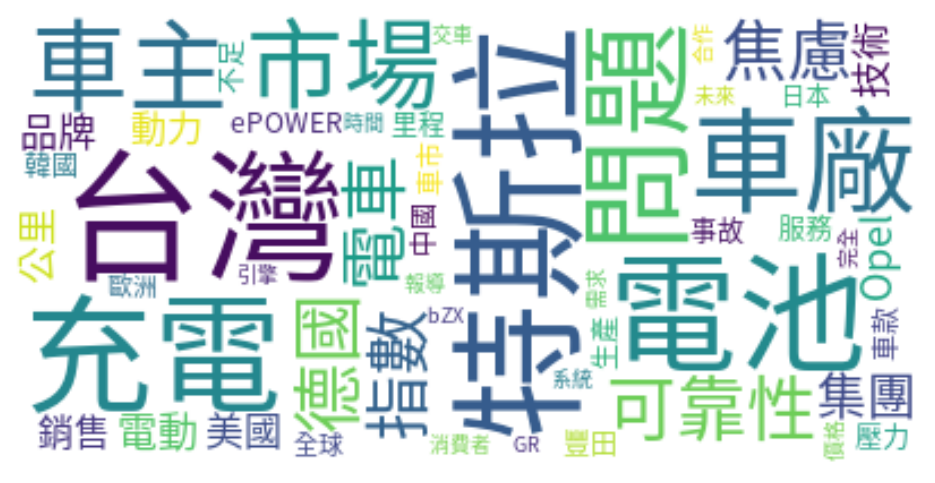

In [ ]:
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=50, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

主要討論"充電"、"電池"、"台灣"、"特斯拉"、"車廠"。

2022年6月後

In [ ]:
start_date = pd.Timestamp('2022-06-30')
mask = (ptt_liwc_df['artDate'] > start_date)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

D:\Users\dnlki\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


(-0.5, 399.5, 199.5, -0.5)

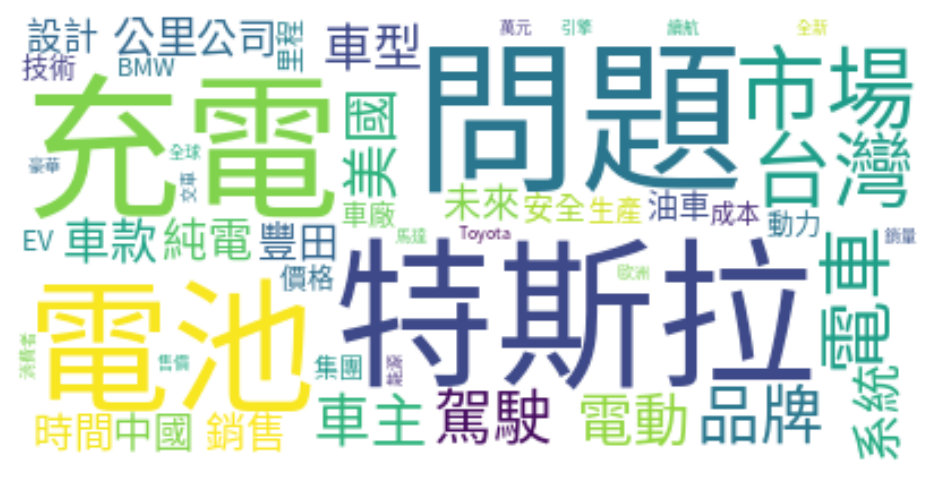

In [ ]:
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=50, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

主要討論"特斯拉"、"充電"、"問題"、"電池"、"市場"。

### 7. 這些關鍵字和購買因素是否有相關（共線圖）

計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)  

In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1] # 篩選掉停用字與字元數大於1的詞彙
    return seg_list
# 重新進行斷詞
data = sent_df.copy()
data['word'] = data.sentence.apply(getToken)
data = data.explode('word')

In [ ]:
# 再次計算各詞彙在各文章中出現的次數
word_count = data.groupby(['artDate','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)

In [ ]:
# 取常一起出現的bigram pair 前1500筆
b = {k:v for k,v in bigramfdist.most_common(1500)}
# 建立DataFrame
bigram_df = pd.DataFrame(list(b), columns=['word','word2']).assign(n=b.values())
#計算phi值
def phi_cor(df):
    # total x
    nx = len(set(word_count[word_count["word"]==df["word"]]["artDate"]))
    tnx = len(sent_df)-nx
    # total y
    ny = len(set(word_count[word_count["word"]==df["word2"]]["artDate"]))
    tny = len(sent_df)-ny
    # 有x 有y
    x_ls = list(word_count[word_count["word"]==df["word"]]["artDate"]) #單獨有x
    y_ls = list(word_count[word_count["word"]==df["word2"]]["artDate"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    # 有x 沒有y
    nxo = nx-nxy
    # 沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(sent_df["artDate"]))-uxy) #取差集:全-有x有y
    # 沒有x 有y
    noy = ny-nxy
    # print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

In [ ]:
word_cors = bigram_df[bigram_df["cor"]>0.95]
word_cors.reset_index(inplace=True, drop=True)
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(word_cors)):
    g.add_edge(word_cors["word"][i], word_cors["word2"][i], weight=word_cors["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*10 for w in  g.edges(data=True)]

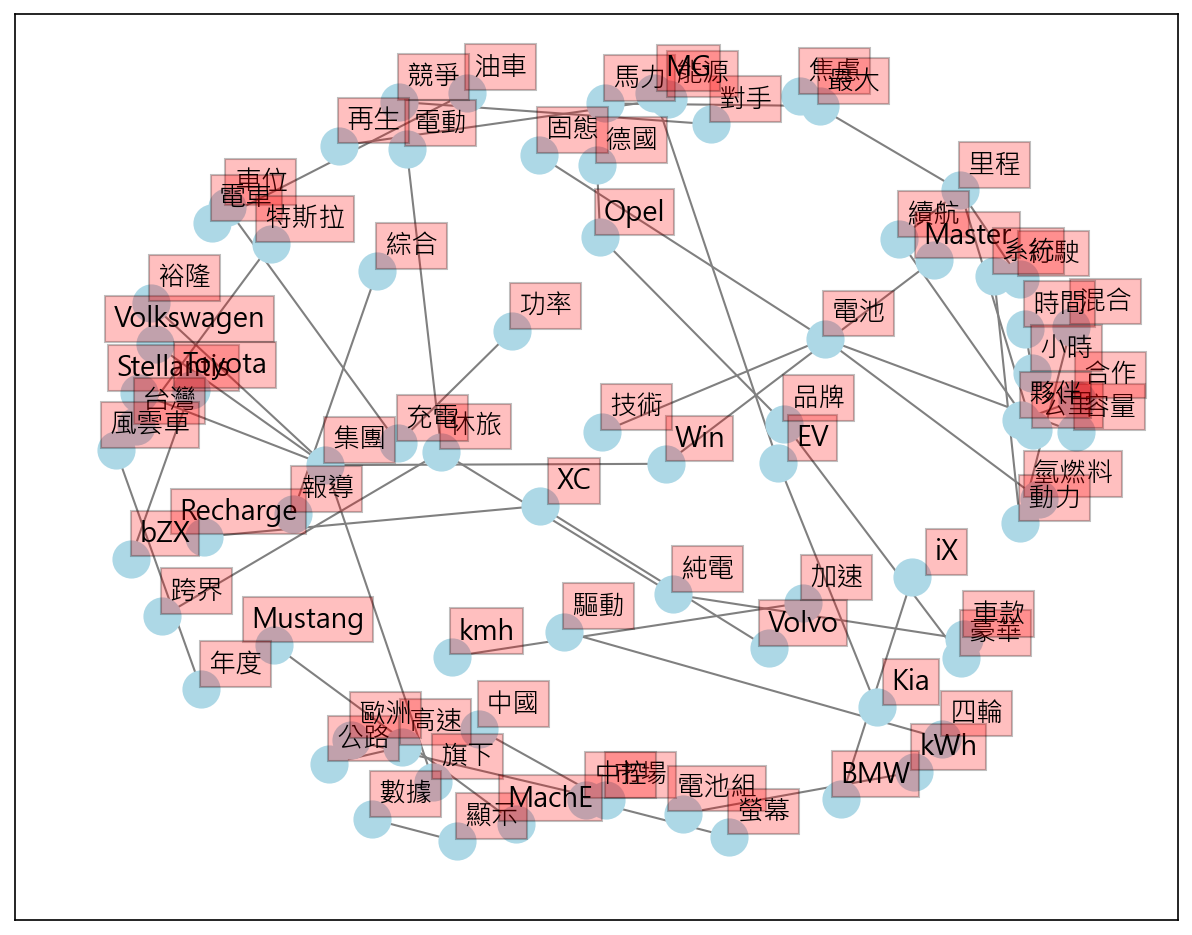

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

民眾特別關注電動車的廠牌和電動車的充電電池。

Stellantis和鴻海電動車合作。<br>
Mustang系列的MachE是福特推出的電動車。<br>
特斯拉中控螢幕電池組是大家最常討論特斯拉的重點。<br>
大家在意電動車的驅動方式、加速。

### 結論

我們主要收集了過去一年PTT汽車版中關於電動車的資料，可以發現在台灣較有代表性的論壇PTT中，對於電動車大家較多討論的是「**電池、充電、續航、問題、特斯拉**」，民眾很在意電動車的電池好不好、充電是否快速以及會不會有其他衍生的問題，這當然也直接影響到了電動車的續航能力，讓消費者有**里程焦慮**的情況產生，相較於汽油車，現在的電動車在低電量時常讓駕駛不確定到底還能開多遠，因此建議未來針對台灣市場，若電動車廠商能夠解決上述所提到的問題，想必能夠比以往更加順利地打進台灣消費者的心，讓在台銷售量有所成長。